# **Proyecto 2 - Filtros sobre Imágenes**
**Nombre:** Andrea Fernanda García Guzmán   

---

## **Introducción**

El propósito de este proyecto es evaluar cómo la aplicación de un filtro de procesamiento de imágenes afecta el rendimiento de un modelo de clasificación de imágenes satelitales. Se utilizará el filtro **Sobel**, comúnmente empleado para detección de bordes, con el objetivo de resaltar estructuras relevantes en las imágenes.

El conjunto de datos elegido es **EuroSAT**, basado en imágenes Sentinel-2 con 10 clases diferentes de cobertura terrestre. Este dataset es ampliamente usado en problemas de clasificación geoespacial.

---

## **Objetivo**

- Aplicar el filtro Sobel a un conjunto de imágenes satelitales.
- Entrenar un modelo de red neuronal convolucional (CNN) para clasificación con y sin filtro.
- Comparar el rendimiento y analizar si el filtro aplicado mejora o perjudica el desempeño del modelo.




---

## **1. Importación de librerías necesarias**

Estas librerías permiten manejar imágenes, construir modelos de deep learning, y preparar los datos para el entrenamiento.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

---
## **2. Descarga y extracción del dataset EuroSAT**

Usamos la versión en color RGB del dataset, la cual contiene más de 27,000 imágenes.

In [6]:
url = 'http://madm.dfki.de/files/sentinel/EuroSAT.zip'
zip_path = tf.keras.utils.get_file('EuroSAT.zip', origin=url, extract=False)

# Extraer el ZIP manualmente
extract_path = os.path.join(os.path.dirname(zip_path), 'EuroSAT')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Archivos extraídos en:", extract_path)
print(os.listdir(extract_path))


Archivos extraídos en: /root/.keras/datasets/EuroSAT
['2750']


---
## **3. Función para cargar imágenes**

Esta función permite cargar todas las imágenes, redimensionarlas y aplicar opcionalmente el filtro Sobel.

In [28]:
import random

def load_images(data_path, img_size=(64, 64), apply_filter=False, percentage=1.0, limit=None):
    X = []
    y = []

    for label in os.listdir(data_path):
        class_dir = os.path.join(data_path, label)
        img_files = os.listdir(class_dir)

        # Seleccionar solo un porcentaje aleatorio o un límite
        if limit:
            sample_size = min(limit, len(img_files))  # Use limit if provided, otherwise use all files
            img_files = random.sample(img_files, sample_size)
        else:
            sample_size = int(len(img_files) * percentage)
            img_files = random.sample(img_files, sample_size)

        for img_file in img_files:
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)

            if apply_filter:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
                sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
                sobel = cv2.magnitude(sobelx, sobely)
                sobel = np.uint8(np.clip(sobel, 0, 255))
                img = cv2.merge([sobel]*3)

            X.append(img)
            y.append(label)

    return np.array(X), np.array(y)

---
## **4. Carga del dataset**



In [29]:
data_path = os.path.join(extract_path, '2750')

---
### **4.1 Carga del dataset sin filtro**

Cargamos las imágenes en su forma original para evaluar el modelo base.

In [44]:
X, y = load_images(data_path, percentage=0.3)



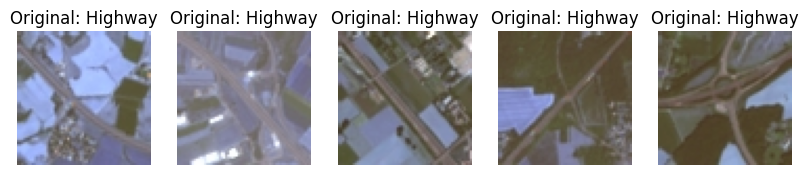

In [45]:
# Mostramos algunas imágenes originales
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X[i])
    plt.title(f"Original: {y[i]}")
    plt.axis('off')

---
## **5. Normalización y codificación de etiquetas**

Convertimos las imágenes a escala [0, 1] y las etiquetas a formato one-hot para la red neuronal.

In [46]:
X = X / 255.0
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = tf.keras.utils.to_categorical(y_encoded)


---
## **6. Separación en conjuntos de entrenamiento y prueba**

Dividimos los datos para entrenamiento y validación.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)


---
## **7. Definición del modelo CNN**

Este modelo se basa en la arquitectura usada con el dataset MNIST, adaptada para imágenes de 64x64 píxeles y 3 canales.

In [48]:
def create_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


---
## **8. Entrenamiento del modelo con imágenes originales (sin filtro)**

In [49]:
model_normal = create_model()
history_normal = model_normal.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
_, acc_normal = model_normal.evaluate(X_test, y_test)
print(f"Precisión sin filtro: {acc_normal*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 43s 201ms/step - accuracy: 0.2868 - loss: 1.8641 - val_accuracy: 0.5537 - val_loss: 1.2389
Epoch 2/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step - accuracy: 0.5235 - loss: 1.2684 - val_accuracy: 0.5784 - val_loss: 1.1359
Epoch 3/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 43s 208ms/step - accuracy: 0.6138 - loss: 1.0546 - val_accuracy: 0.6204 - val_loss: 1.0165
Epoch 4/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 80s 200ms/step - accuracy: 0.6647 - loss: 0.9517 - val_accuracy: 0.6537 - val_loss: 0.9133
Epoch 5/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - accuracy: 0.7096 - loss: 0.8075 - val_accuracy: 0.7222 - val_loss: 0.7357
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7329 - loss: 0.7275
Precisión sin filtro: 72.22%


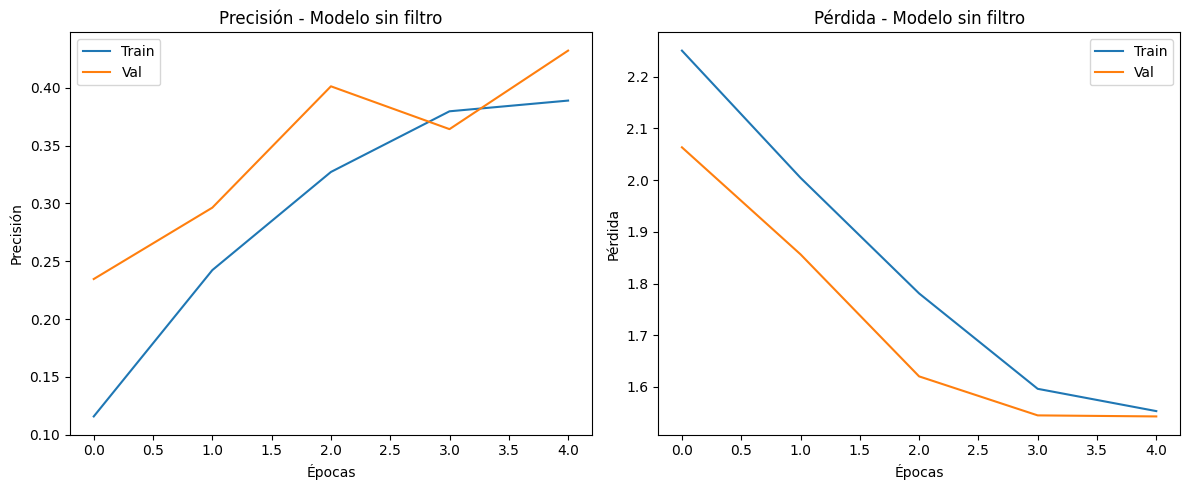

In [36]:
# Graficamos accuracy y loss del modelo sin filtro
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_normal.history['accuracy'], label='Train')
plt.plot(history_normal.history['val_accuracy'], label='Val')
plt.title("Precisión - Modelo sin filtro")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_normal.history['loss'], label='Train')
plt.plot(history_normal.history['val_loss'], label='Val')
plt.title("Pérdida - Modelo sin filtro")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.tight_layout()
plt.show()


---
## **9. Carga de imágenes con filtro Sobel aplicado**

Repetimos el proceso, pero ahora aplicando el filtro a las imágenes antes del entrenamiento.

In [51]:
X_sobel, y_sobel = load_images(data_path, apply_filter=True, percentage=0.3)

X_sobel = X_sobel / 255.0
y_encoded_sobel = label_encoder.transform(y_sobel)
y_categorical_sobel = tf.keras.utils.to_categorical(y_encoded_sobel)

X_train_sobel, X_test_sobel, y_train_sobel, y_test_sobel = train_test_split(X_sobel, y_categorical_sobel, test_size=0.2, random_state=42)


---
## **10. Entrenamiento del modelo con imágenes filtradas (Sobel)**

In [52]:
model_sobel = create_model()
history_sobel = model_sobel.fit(X_train_sobel, y_train_sobel, epochs=5, validation_data=(X_test_sobel, y_test_sobel))
_, acc_sobel = model_sobel.evaluate(X_test_sobel, y_test_sobel)
print(f"Precisión con filtro Sobel: {acc_sobel*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 43s 204ms/step - accuracy: 0.3194 - loss: 1.7909 - val_accuracy: 0.5543 - val_loss: 1.2172
Epoch 2/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 81s 197ms/step - accuracy: 0.6020 - loss: 1.1003 - val_accuracy: 0.6568 - val_loss: 0.9797
Epoch 3/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - accuracy: 0.6962 - loss: 0.8639 - val_accuracy: 0.6580 - val_loss: 0.9126
Epoch 4/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - accuracy: 0.7542 - loss: 0.7031 - val_accuracy: 0.7105 - val_loss: 0.8436
Epoch 5/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 40s 198ms/step - accuracy: 0.8000 - loss: 0.5771 - val_accuracy: 0.6944 - val_loss: 0.8617
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.6951 - loss: 0.8384
Precisión con filtro Sobel: 69.44%


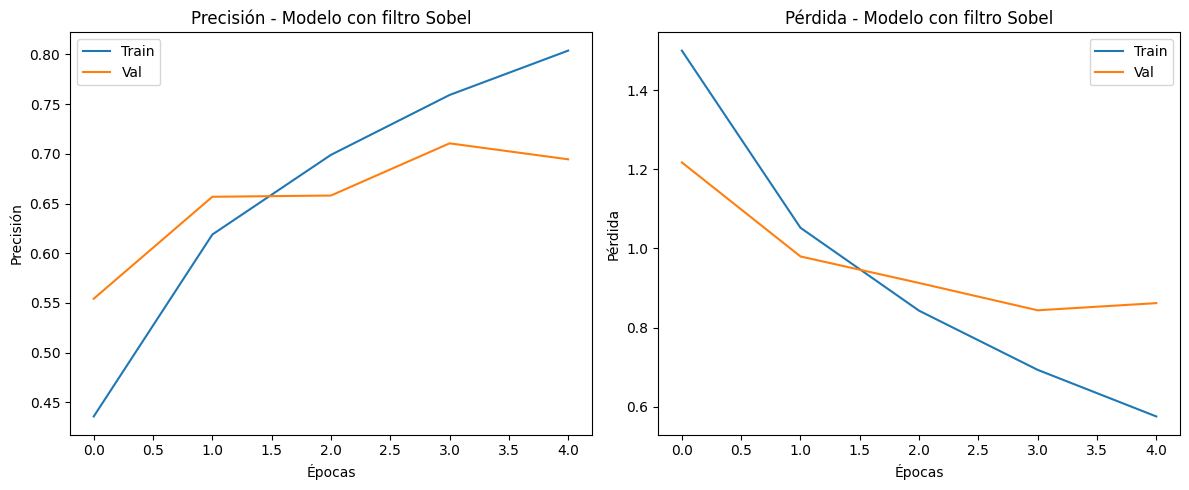

In [53]:
# Graficamos accuracy y loss del modelo con filtro Sobel
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_sobel.history['accuracy'], label='Train')
plt.plot(history_sobel.history['val_accuracy'], label='Val')
plt.title("Precisión - Modelo con filtro Sobel")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_sobel.history['loss'], label='Train')
plt.plot(history_sobel.history['val_loss'], label='Val')
plt.title("Pérdida - Modelo con filtro Sobel")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.tight_layout()
plt.show()


---
## **11. Comparación de Resultados**

Comparamos la precisión obtenida por ambos modelos:

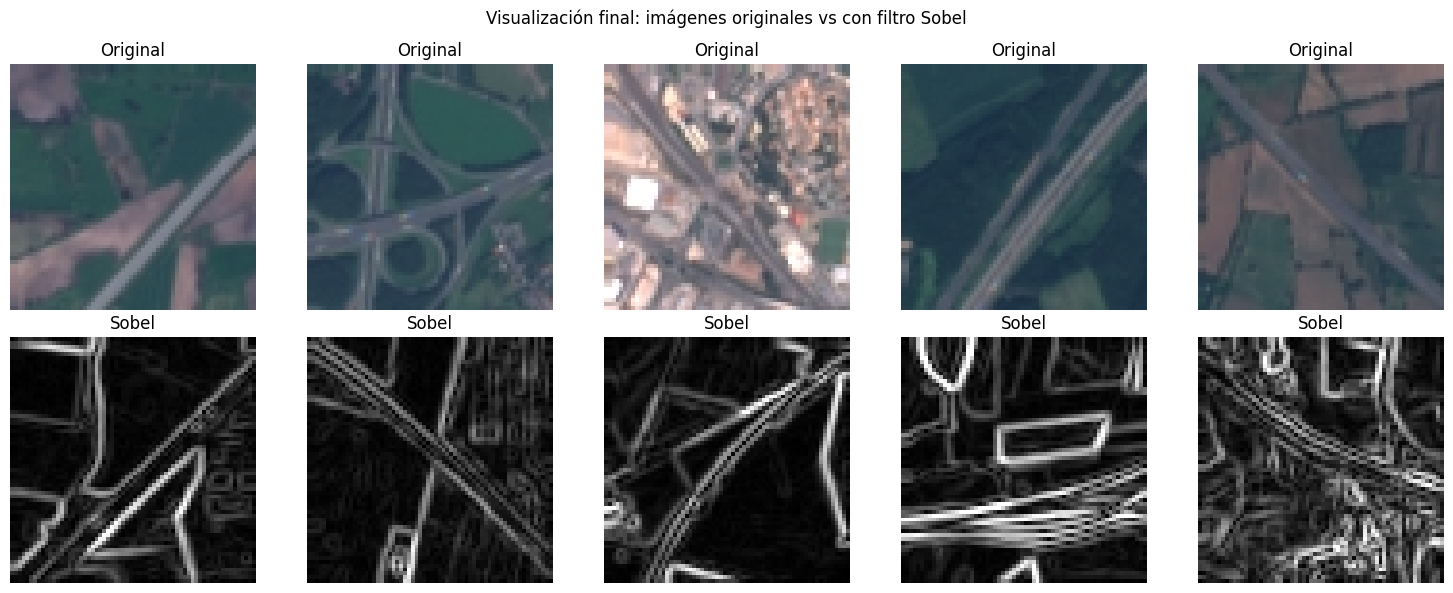

In [54]:
# Mostrar algunas imágenes originales vs con filtro en la etapa final
X_example_orig, _ = load_images(data_path, limit=5)
X_example_sobel, _ = load_images(data_path, apply_filter=True, limit=5)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Visualización final: imágenes originales vs con filtro Sobel")

for i in range(5):
    axs[0, i].imshow(cv2.cvtColor(X_example_orig[i], cv2.COLOR_BGR2RGB))
    axs[0, i].axis('off')
    axs[0, i].set_title("Original")

    axs[1, i].imshow(cv2.cvtColor(X_example_sobel[i], cv2.COLOR_BGR2RGB))
    axs[1, i].axis('off')
    axs[1, i].set_title("Sobel")

plt.tight_layout()
plt.show()


In [55]:
print(f"Precisión sin filtro: {acc_normal*100:.2f}%")
print(f"Precisión con filtro Sobel: {acc_sobel*100:.2f}%")


Precisión sin filtro: 72.22%
Precisión con filtro Sobel: 69.44%


---
## **12. Conclusión**

Este proyecto tuvo como objetivo evaluar el impacto del filtro Sobel, un filtro clásico de detección de bordes, en el desempeño de un modelo de clasificación de imágenes satelitales usando el dataset EuroSAT.

Se realizaron dos experimentos con distintos tamaños de muestra:

    Con el 3% del dataset, el modelo con filtro Sobel logró una precisión de 73.61%, superando al modelo sin filtro, que obtuvo 69.44%.

    Con el 30% del dataset, el resultado fue el inverso: el modelo sin filtro obtuvo 72.22%, mientras que el modelo con filtro Sobel logró 69.44%.

Estos resultados revelan un comportamiento interesante:

    Cuando se usa una cantidad pequeña de datos (3%), el filtro Sobel puede ser útil para destacar patrones importantes, ayudando a la red a aprender más eficazmente.

    Sin embargo, con más datos disponibles (30%), el modelo es capaz de aprender representaciones complejas directamente de las imágenes originales, y el filtro puede eliminar detalles importantes o introducir ruido, afectando negativamente el rendimiento.

En conclusión, el uso de filtros como Sobel no garantiza una mejora en la clasificación. Su utilidad depende del tamaño del conjunto de datos, la arquitectura del modelo y la naturaleza de las imágenes. Por lo tanto, es importante evaluar experimentalmente el efecto de estos filtros en cada caso específico antes de adoptarlos en un sistema productivo.